In [5]:
#Load Embeddings model

from transformers import AutoTokenizer, AutoModel
import torch

# Load the pre-trained BERT model and tokenizer
model_name = "cross-encoder/ms-marco-TinyBERT-L-2-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
embeddingsmodel = AutoModel.from_pretrained(model_name)

# Check if a GPU is available and move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddingsmodel.to(device)

#Test functionaliy
# # Tokenize the text field and create a tensor with the token IDs
# text_field = "This is an example text field."
# inputs = tokenizer(text_field, return_tensors="pt", padding=True, truncation=True)
# inputs = {k: v.to(device) for k, v in inputs.items()}

# # Obtain the embeddings
# with torch.no_grad():
#     outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state

# # Calculate the average embedding
# avg_embedding = embeddings.mean(dim=1).squeeze().cpu().numpy()
# avg_embedding

Some weights of the model checkpoint at cross-encoder/ms-marco-TinyBERT-L-2-v2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [6]:
#Load SampleData.csv into a dataframe / turn labels into embeddings
import pandas as pd
df = pd.read_csv('SampleData.csv')

#Get field AdjustmentName as list
AdjustmentNames = df['AdjustmentName'].tolist()

#Loop over every field and turn it into an embedding
queryList=[]
for AdjustmentName in AdjustmentNames:
    text_field = AdjustmentName.replace('_', ' ').replace('-', ' ')
    inputs = tokenizer(text_field, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = embeddingsmodel (**inputs)
        embeddings = outputs.last_hidden_state

    #Turn embedding into a regular vector
    avg_embedding = embeddings.mean(dim=1).squeeze().cpu().numpy()
    queryList.append(avg_embedding)



In [7]:
#Onehot encode the existing adjustment names
#Get only the AdjustmentName column
df2=df[['AdjustmentName']]

#Get list of unique values produce mapping to numeric index
uniqueValues=df2['AdjustmentName'].unique()
uniqueValues.sort()

#Create a dictionary of unique values
uniqueValuesDict={}
for i in range(len(uniqueValues)):
    uniqueValuesDict[uniqueValues[i]]=i

#Create an inverse dictionary of unique values
uniqueValuesDictInverse={}
for i in range(len(uniqueValues)):
    uniqueValuesDictInverse[i]=uniqueValues[i]

#Get AdjustmentName column as a list
AdjustmentNames = df2['AdjustmentName'].tolist()

#Replace AdjustmentName with numeric index
for i in range(len(AdjustmentNames)):
    AdjustmentNames[i]=uniqueValuesDict[AdjustmentNames[i]]

#Make new dataframe from AdjustmentNames
y = pd.DataFrame(AdjustmentNames, columns=['AdjustmentName'])

#onehot encode the AdjustmentName column
y = pd.get_dummies(y, columns=['AdjustmentName'])

#Unpack lists in queryList and turn into a dataframe grid
import numpy as np
df_query = pd.DataFrame(np.array(queryList).reshape(len(queryList), 128))


#df_query
y

,AdjustmentName_0,AdjustmentName_1,AdjustmentName_2,AdjustmentName_3,AdjustmentName_4,AdjustmentName_5,AdjustmentName_6,AdjustmentName_7
0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
27907,0,0,0,0,0,0,1,0
27908,0,0,1,0,0,0,0,0
27909,0,0,1,0,0,0,0,0
27910,1,0,0,0,0,0,0,0


In [8]:
#Break into test and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_query, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))



22329
22329
5583
5583


In [9]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

#Define model
#Build model parameterized so we can do a grid-search on hyperparameters
#model.fit(X_train, y_train, batch_size = 32, epochs = 80)

def CreateModel(neurons=200, dropout=0.2,layers=3):

    #------------------PARAMETERS------------------
    num_classes=len(uniqueValuesDict)

    #Simple feed-forward model. No U-nets or anything fancy
    ann = tf.keras.models.Sequential()

    #Variable number of layers
    for i in range(layers):
        ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))

    #Final dropout layer at last fully connected layer before classification head
    ann.add(tf.keras.layers.Dropout(dropout))
    #ann.add(tf.keras.layers.Dense(units=num_classes, activation='sigmoid'))

    # ann.add(tf.keras.layers.Flatten())
    ann.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


    #Compile!
    ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  
    
    #ann.summary()
    return ann

model = KerasClassifier(build_fn=CreateModel, verbose=0)

param_grid = {
    'epochs': [1,2,4,8,16],
    'neurons': [200, 300, 400],
    "dropout":[0.05,0.1,0.2,0.4],
    "layers":[1,2,4]
}

C:\Users\simon\AppData\Local\Temp\ipykernel_34204\2009610056.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=CreateModel, verbose=0)


In [10]:
#Grid search for model parameters
# from sklearn.model_selection import GridSearchCV
#aModel=CreateModel()
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train, y_train)
# print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#Best score: 1.000000 using {'dropout': 0.05, 'epochs': 1, 'layers': 1, 'neurons': 200}
#Train model
aModel=CreateModel(200,0.05,1)
aModel.fit(X_train, y_train, batch_size = 32, epochs = 2)


Epoch 1/2
698/698 [==============================] - 1s 1ms/step - loss: 0.0177 - accuracy: 0.9863
Epoch 2/2
698/698 [==============================] - 1s 1ms/step - loss: 2.7415e-04 - accuracy: 1.0000


In [10]:
#Validate the model against the test set
y_pred = aModel.predict(X_test)
y_pred = (y_pred > 0.5)

#Get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

#y_pred

125/125 [==============================] - 0s 546us/step


1.0

In [14]:
#Make a prediction
# Tokenize the text field and create a tensor with the token IDs
text_field = "German retail sales fall unexpectedly in October"
inputs = tokenizer(text_field, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}
# Obtain the embeddings
with torch.no_grad():
    outputs = embeddingsmodel(**inputs)
    embeddings = outputs.last_hidden_state

# Calculate the average embedding
avg_embedding = embeddings.mean(dim=1).squeeze().cpu().numpy()
avg_embedding

import numpy as np
df_query = pd.DataFrame(avg_embedding.reshape(1, 128))
df_query

#Make a prediction
ret=aModel.predict(df_query)

#Get the index of the highest value
ret=np.argmax(ret)
#ret

# #Get the AdjustmentName from the index
uniqueValuesDictInverse[ret]



1/1 [==============================] - 0s 34ms/step


'German Retail Downturn'

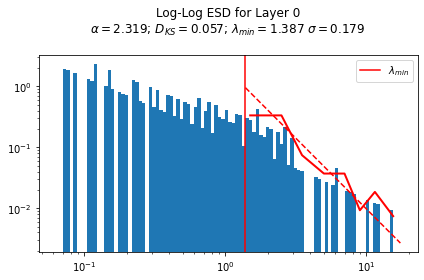

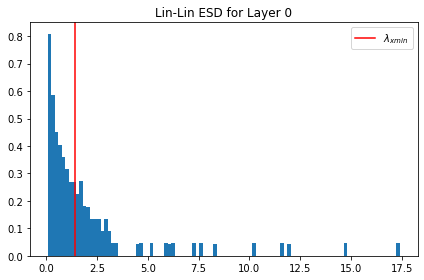

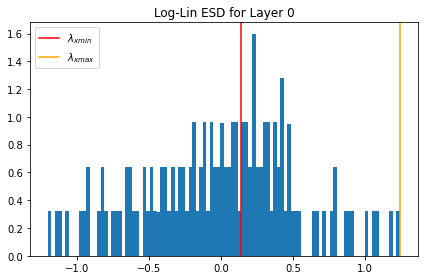

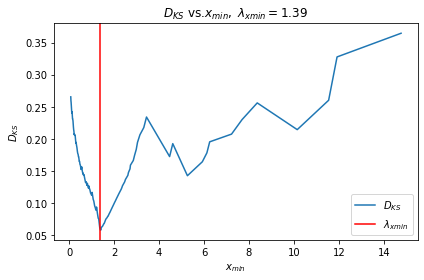

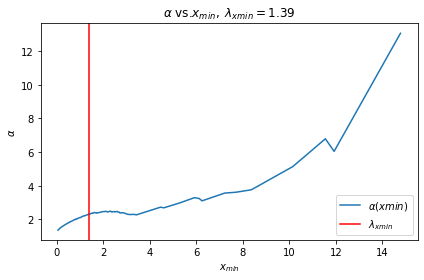

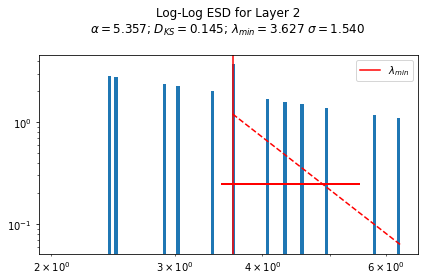

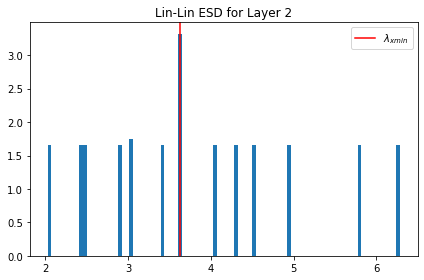

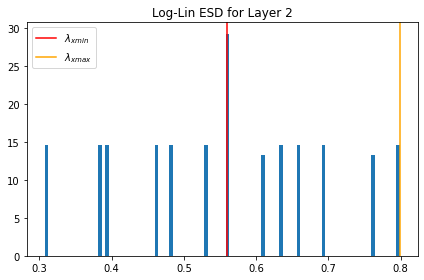

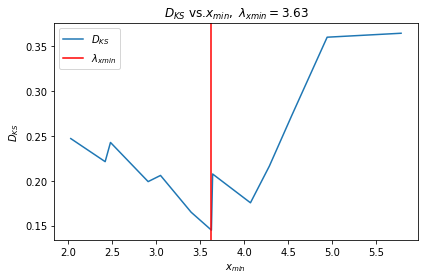

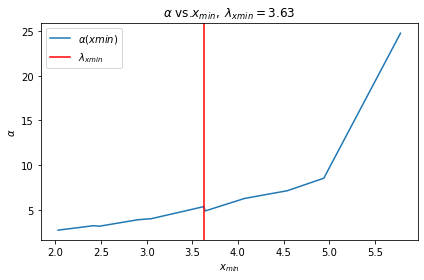

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,0,dense_2,0.057298,128,200,1.562500,2.318774,2.878088,0.96355,True,...,1,0.179462,17.437500,14.398438,success,4.175781,,0,17.437500,1.386719
1,2,dense_3,0.144978,14,200,14.285714,5.357099,4.279401,0.98135,True,...,1,1.540467,6.289062,8.500000,success,2.507812,,0,6.289062,3.626953


<Figure size 432x288 with 0 Axes>

In [16]:
#Weightwatcher
import weightwatcher as ww
watcher = ww.WeightWatcher(model=aModel)
results = watcher.analyze(plot=True)
results

In [19]:
#Save tensorflow model
aModel.save('Models\AdjustmentNameNLP\model.h5')
torch.save(aModel, 'Models\AdjustmentNameNLP\model.pt')

#Save uniqueValuesDictInverse to JSON
import json
with open('Models\AdjustmentNameNLP\softmaxlkp.json', 'w') as fp:
    json.dump(uniqueValuesDictInverse, fp)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-08 12:20:48         1525
metadata.json                                  2023-05-08 12:20:48           64
variables.h5                                   2023-05-08 12:20:48       362904
